In [1]:
module("load", "cuda/10.2")
module("load","pytorch/gpu-cuda-10.2/1.8.0")

In [2]:
import numpy as np
import pandas as pd
import torch
from sklearn import model_selection
from sklearn.metrics import mean_squared_error
import sklearn as sk
from torch.optim import Optimizer
import wandb

In [3]:
from transformers import TrainingArguments, Trainer
from transformers import AdamW, BertTokenizer, AutoModelForSequenceClassification
from transformers import DataCollatorWithPadding
from sklearn.preprocessing import StandardScaler
import gc

In [35]:
wandb.init(project="prot_bert_bfd", entity="jlrestrepol")

In [5]:
%env WANDB_LOG_MODEL=true

env: WANDB_LOG_MODEL=true


In [6]:
device_name = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [7]:
if device_name.type != 'cuda':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: cuda


In [8]:
global path
path = {'data':"./", 'models':'./'}

In [9]:
def train_val_set(charge = np.nan):
    """Function that outputs train and validation set for a given charge state"""
    fig1 = pd.read_pickle(path['data']+'Fig1_powerlaw.pkl')#loads in raw training data
    fig1 = fig1[fig1['Modified sequence'].str.find('(')==-1]#Unmodified seqs
    fig1.loc[:,'Modified sequence'] = fig1['Modified sequence'].str.replace('_','')
    fig1.loc[:,'Modified sequence'] = fig1['Modified sequence'].str.replace('', ' ')
    fig1.loc[:,'Modified sequence'] = fig1['Modified sequence'].apply(lambda x : x[1:-1])
    label_complete = (fig1['CCS'] - fig1['predicted_ccs']).values#residual
    features = fig1[fig1['Charge'] == charge]['Modified sequence']#choose points with given charge, drop charge feature because of 2 heads
    label = label_complete[fig1['Charge'] == charge]#choose appropiate residuals
    x_train, x_test, y_train, y_test = model_selection.train_test_split(features, label, test_size = 0.1, random_state=42)#train/val set split
    global label_scaler
    label_scaler = StandardScaler()
    label_scaler.fit(y_train.reshape(-1, 1))
    y_train = label_scaler.transform(y_train.reshape(-1, 1))
    y_test = label_scaler.transform(y_test.reshape(-1, 1))
    print(f"The Initial Mean Squared Error is: {sk.metrics.mean_squared_error(fig1['CCS'], fig1['predicted_ccs'])}")#prints initial error
    return x_train, x_test, y_train, y_test

In [10]:
class CCSDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]).to(torch.int16) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx]).to(torch.float16)
        return item

    def __len__(self):
        return len(self.labels)

In [11]:
def compute_metrics(eval_pred):
    labels = eval_pred.label_ids
    preds = eval_pred.predictions.flatten()
    mse = mean_squared_error(preds, labels)
    preds_scaled = label_scaler.inverse_transform(preds.reshape(-1, 1))
    labels_scaled = label_scaler.inverse_transform(labels.reshape(-1, 1))
    mse_scaled = mean_squared_error(preds_scaled, labels_scaled)
    return {
        "MSE": mse,
        "MSE scaled" : mse_scaled
    }

In [12]:
checkpoint = "Rostlab/prot_bert_bfd"
tokenizer = BertTokenizer.from_pretrained(checkpoint, do_lower_case=False )
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=1)

Downloading:   0%|          | 0.00/81.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/86.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/361 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.57G [00:00<?, ?B/s]

Some weights of the model checkpoint at Rostlab/prot_bert_bfd were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not init

In [36]:
x_train, x_test, y_train, y_test = train_val_set(3)
train_tokenized = tokenizer(x_train.values.tolist(), padding=True, return_tensors='pt')
test_tokenized = tokenizer(x_test.values.tolist(), padding=True, return_tensors='pt')
train_dataset = CCSDataset(train_tokenized, y_train)
test_dataset = CCSDataset(test_tokenized, y_test)
del x_train, x_test, y_train, y_test, train_tokenized, test_tokenized

The Initial Mean Squared Error is: 384.9004049893965


In [37]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [38]:
torch.cuda.empty_cache()
gc.collect()

46

In [44]:
training_args = TrainingArguments("test-trainer", 
                                  per_device_train_batch_size=64, per_device_eval_batch_size=64, num_train_epochs=30, gradient_accumulation_steps=64,
                                  logging_steps=40, seed=3, evaluation_strategy="epoch", save_strategy="epoch", fp16=True,
                                  load_best_model_at_end=True, metric_for_best_model="eval_loss", warmup_steps=4, learning_rate=3e-05,
                                  fp16_opt_level="01", logging_dir="./logs", report_to = 'wandb',run_name = 'lr-default_training')

PyTorch: setting up devices


In [45]:
trainer = Trainer(
    model,
    training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

Using amp fp16 backend


In [41]:
predictions = trainer.predict(test_dataset)

***** Running Prediction *****
  Num examples = 11637
  Batch size = 64
/u/jrlopez/conda-envs/ccs/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


In [42]:
predictions.metrics

{'test_loss': 1.6586984395980835,
 'test_MSE': 1.6586982011795044,
 'test_MSE scaled': 1279.50341796875,
 'test_runtime': 10.0428,
 'test_samples_per_second': 1158.744,
 'test_steps_per_second': 18.122}

In [ ]:
trainer.train()

***** Running training *****
  Num examples = 104733
  Num Epochs = 30
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 4096
  Gradient Accumulation steps = 64
  Total optimization steps = 750
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
/u/jrlopez/conda-envs/ccs/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


Epoch,Training Loss,Validation Loss,Mse,Mse scaled
0,No log,0.417258,0.417258,321.871338
1,0.413400,0.397057,0.397057,306.299866
2,0.413400,0.396370,0.396370,305.767853


***** Running Evaluation *****
  Num examples = 11637
  Batch size = 64
Saving model checkpoint to test-trainer/checkpoint-25
Configuration saved in test-trainer/checkpoint-25/config.json
Model weights saved in test-trainer/checkpoint-25/pytorch_model.bin
tokenizer config file saved in test-trainer/checkpoint-25/tokenizer_config.json
Special tokens file saved in test-trainer/checkpoint-25/special_tokens_map.json
/u/jrlopez/conda-envs/ccs/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
***** Running Evaluation *****
  Num examples = 11637
  Batch size = 64
Saving model checkpoint to test-trainer/checkpoint-50
Configuration saved in test-trainer/checkpoint-50/config.json
Model weights saved in test-trainer/checkpoint-50/pytorch_model.bin
tokenizer config file saved in test-trai

In [34]:
wandb.finish()

In [24]:
df_fig4 = pd.read_pickle(path['data']+'Fig4_powerlaw.pkl')
df_fig4 = df_fig4[df_fig4['Modified_sequence'].str.find('(')==-1]#Unmodified seqs
df_fig4.loc[:,'Modified_sequence'] = df_fig4['Modified_sequence'].str.replace('_','')
df_fig4.loc[:,'Modified_sequence'] = df_fig4['Modified_sequence'].str.replace('', ' ')
df_fig4.loc[:,'Modified_sequence'] = df_fig4['Modified_sequence'].apply(lambda x : x[1:-1])

test_tokenized = tokenizer(df_fig4['Modified_sequence'].values.tolist(), padding=True, return_tensors='pt')
label_complete = (df_fig4['CCS'] - df_fig4['predicted_ccs']).values#residual
test_dataset = CCSDataset(test_tokenized, label_complete)

In [26]:
predictions = trainer.predict(test_dataset)
preds = predictions.predictions.flatten()
preds_scaled = label_scaler.inverse_transform(preds.reshape(-1, 1))

***** Running Prediction *****
  Num examples = 126328
  Batch size = 64
/u/jrlopez/conda-envs/ccs/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


In [27]:
def test_set_one_charge_results(res, charge = 2):
    '''Plots in the test set: scatter and histogram'''
    '''### Load-in model and Data
    df_fig4 = pd.read_pickle(path['data']+'Fig4_powerlaw.pkl')
    df_fig4 = df_fig4[df_fig4['Modified sequence'].str.find('(')==-1]#Unmodified seqs
    df_fig4.loc[:,'Modified sequence'] = df_fig4['Modified sequence'].str.replace('_','')
    df_fig4.loc[:,'Modified sequence'] = df_fig4['Modified sequence'].str.replace('', ' ')
    df_fig4.loc[:,'Modified sequence'] = df_fig4['Modified sequence'].apply(lambda x : x[1:-1])
    tokenizer(x_train.values.tolist(), padding=True, return_tensors='pt')
    path = f'../models/transformer_ch{charge}/checkpoints/best'
    ### Separate by charge and make predictions, change after all the models are trained
    res  = model.predict(features_fig4[features_fig4[:,-1] == charge][:,:-1])'''
    res = res[df_fig4['Charge']==charge]
    pred_ccs = df_fig4[df_fig4['Charge']==charge]['predicted_ccs'] + res.flatten()
    err_rel = (pred_ccs - df_fig4[df_fig4['Charge']==charge]['CCS'])/pred_ccs*100
    ### Histogram and scatter plot
    fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 6))
    ax[0].hist(err_rel, bins = 50, label = f'MAD = {np.round(scipy.stats.median_abs_deviation(err_rel), 4)}')
    ax[0].set_xlabel('Relative Error of CCS')
    ax[0].set_ylabel('Counts')
    ax[0].set_title('Relative error of CCS w.r.t Ground Truth, Charge 2')
    ax[0].legend()

    corr, _ = scipy.stats.pearsonr(df_fig4[df_fig4['Charge']==charge]['CCS'],pred_ccs)
    ax[1].scatter(df_fig4[df_fig4['Charge']==charge]['CCS'],pred_ccs, label = f'Corr : {np.round(corr, 3)}', s = 0.1)
    ax[1].set_xlabel('CCS')
    ax[1].set_ylabel('Predicted CCS')
    ax[1].set_title('Scatter Plot CCS vs predicted CCS, Charge 2')
    ax[1].plot(np.arange(300,600), np.arange(300,600), 'b--')
    ax[1].legend()


In [29]:
import matplotlib.pyplot as plt
import scipy

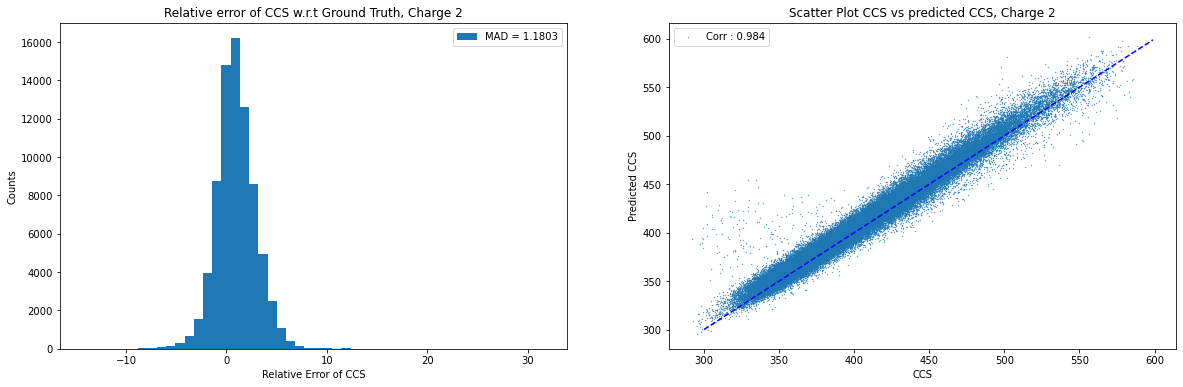

In [30]:
test_set_one_charge_results(preds_scaled)

In [32]:
from sklearn.metrics import mean_absolute_error

In [33]:
mean_absolute_error(preds_scaled[df_fig4['Charge']==2].flatten() + df_fig4[df_fig4['Charge']==2]['predicted_ccs'].values, df_fig4[df_fig4['Charge']==2]['CCS'])

7.013937183978168

In [58]:
res_rnn = df_fig4['label Prediction 0'] - df_fig4['predicted_ccs']

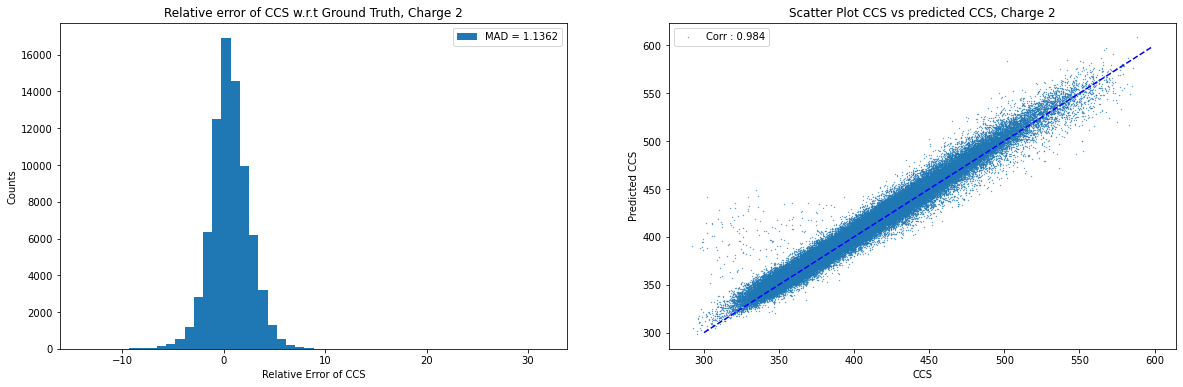

In [62]:
test_set_one_charge_results(res_rnn.to_numpy().reshape((-1,1)))

In [73]:
mean_absolute_error(df_fig4[df_fig4['Charge']==2]['label Prediction 0'].values, df_fig4[df_fig4['Charge']==2]['CCS'])

6.389861678832851